# How do Machines Learn?

If we want to teach a machine to learn, how do we do this? We must first come up with a model. This model is going to have some parameters, variables, that will need to be tuned to the task at hand. However, the obvious question is how do we tune these parameters? Clearly we must do this in a smart manner or else our machine will struggle to learn anything...

In broad strokes, any Machine Learning (ML) algorithm can be summarized with the following components:
 * A (parametrized) model
 * A learning algorithm
 * A learning objective
 
This lab is going to focus on the learning algorithm and learning objective aspects of machine learning before we delve into the realm of machine learning models.

In [2]:
from matplotlib import pyplot as plt
import torch

In [3]:
# Pretty plotting config
%run plot_conf.py

In [4]:
# Set style (need to be in a new cell)
plt_style()

# 1.0 - The Learning Objective & Model
The learning objective, simply put, is what we are trying to teach the machine to do. In more general terms, what we are typically given is some input data $\vec{X}$ that we are trying to use to map to some label or prediction $\vec{y}$. This could be trying to predict future stock market prices given past stock market prices, label images of animals, or identify particles produced at the Large Hadron Collider. In each example given, we have some samples, $\vec{x}$, from our data, $\vec{X}$, that is readily available, $\vec{x} \in \vec{X}$, in which we are trying to use to create some predictions $\hat{y}$ that match our expected result $\vec{y}$ (ground truth).

In fact, what we are searching for is the relationship:
$$ \hat{y} = f\left(\vec{x}; \vec{\theta}\right) $$
where $f(\vec{x}; \vec{\theta})$ is some magical function that perfectly predicts the desired output. This magical function $f$ is the machine learning model which is parametrized by the vector of parameters $\vec{\theta}$. 

For now let's imagine the simple case of a 1D linear model with y-intercept set to zero:
$$ f\left(\vec{x}; \vec{\theta}\right) = \theta_1 \cdot x_1 $$
This model takes in a one dimensional vector and uses a one dimensional parameter vector to create a predicted output that is also one dimensional. This is quite possibly the simplest machine learning model!

Now let's build this model with PyTorch!

In [314]:
theta = torch.Tensor(1).random_(10)

In [315]:
theta

tensor([3.])

In [316]:
theta.requires_grad = True

In [317]:
N = 100 # this is number of samples

In [318]:
x = (10 * torch.rand(N).reshape(N, 1))  # reshape is to ensure it is 10,000 samples of 1D vectors

In [319]:
slope = 4.928 # This is a parameter that our model needs to learn to predict accurately
y_intercept = -12.52 # This is another parameter that our model needs to learn to predict accurately
noise = torch.randn(N).reshape(N, 1) # in reality you always have some "noise" with your given data's "true" predicted outcome
#noise *= 2
y_true = slope * x + noise + y_intercept
y_pred = theta[0] * x

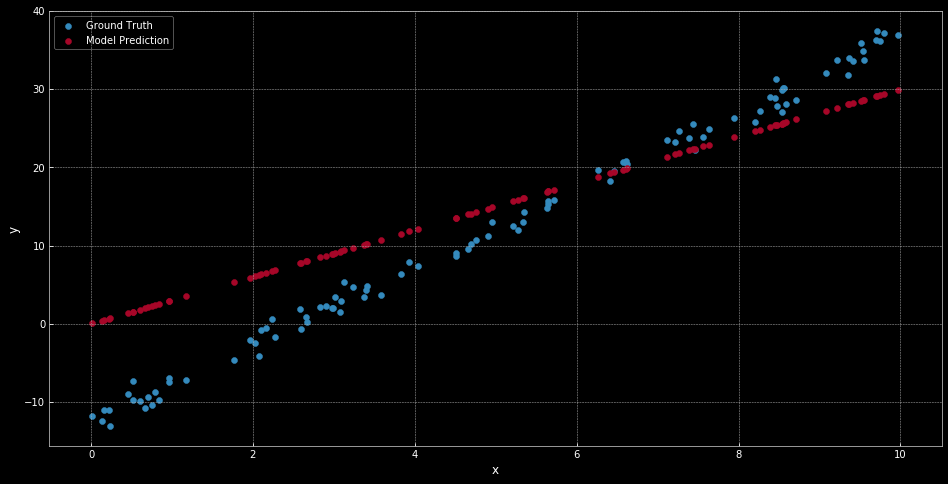

In [320]:
plt.scatter(x.detach().numpy(), y_true.detach().numpy(), label="Ground Truth")
plt.scatter(x.detach().numpy(), y_pred.detach().numpy(), label='Model Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Now clearly our model prediction varies greatly (is not correct) with respect to the ground truth. We need a way to score how incorrectly our model is predicting the output so that we can gauge how well our model is performing. To understand how to do this, we first need to understand what task it is we are trying to accomplish.

This task being described here is a regression task. This is because we are trying to predict a range of values, 0 to 40-ish in this case, as seen by the histogram below.

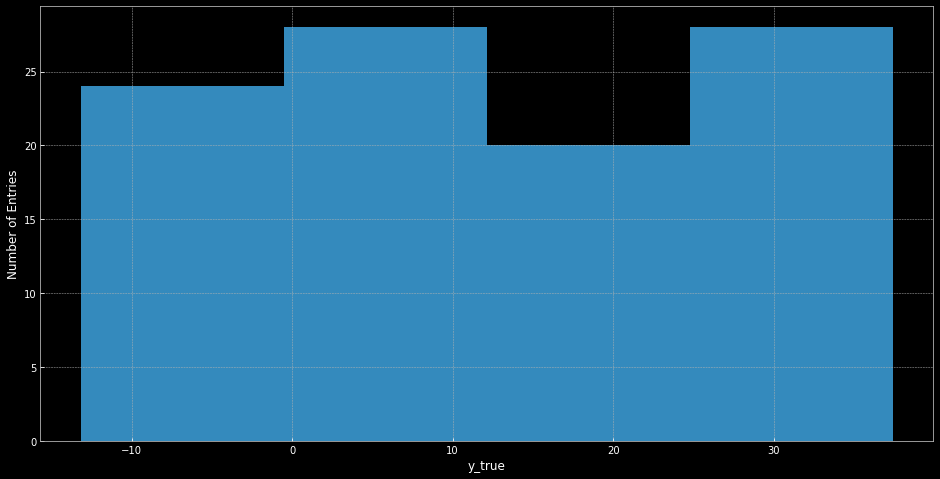

In [321]:
plt.hist(y_true.detach().flatten(), bins=4)
plt.ylabel('Number of Entries')
plt.xlabel('y_true')
plt.show()

The other type of task that is typically performed with machine learning is classification. In classification tasks you are trying to classify or map inputs to a class, typically represented by 0 or 1 for binary classification or one-hot vectors for multiclass classification (0001, 0010, 0100, 1000 for 4 different classes, for example).

Since this is a regression task, we can just take the squared difference between the ground truth value and predicted value, which we will now call our loss function, $\mathcal{L}$.
$$
\mathcal{L}\left(\hat{y}, \vec{y}\right) = \mathcal{L}\left(f\left(\vec{x};\vec{\theta}\right), \vec{y}\right) = \frac{1}{2N}\sum_{i = 1}^{N} \sum_{j = 1}^D \left(\hat{y}_j^{\left(i\right)} - y_j^{\left(i\right)}\right)^2
$$
where N is the number of datapoints, D is the number of dimensions (1 in the above case), $\hat{y}$ are your predictions from your machine learning model, and $y$ are the ground truth values. This loss function is a difference since we need a measure of how different they are. This loss functions is also squared so that way it is positive definite. This means if the predicted value is larger than or less than the ground truth value we still incur a positive loss, which is the behavior we desire. We divide by N so that this is the average loss, which makes it easier to compare if you have varying numbers of samples (more on that later). The division by 2 is customary for making the learning algorithm calculations prettier which we will discuss shortly. You can cook up multiple different types of loss functions, which we will explore throughout this lab. This particular loss function is called the *mean squared error loss function* or MSE for short.

In [322]:
loss_per_datapoint = (y_true - y_pred).pow(2)

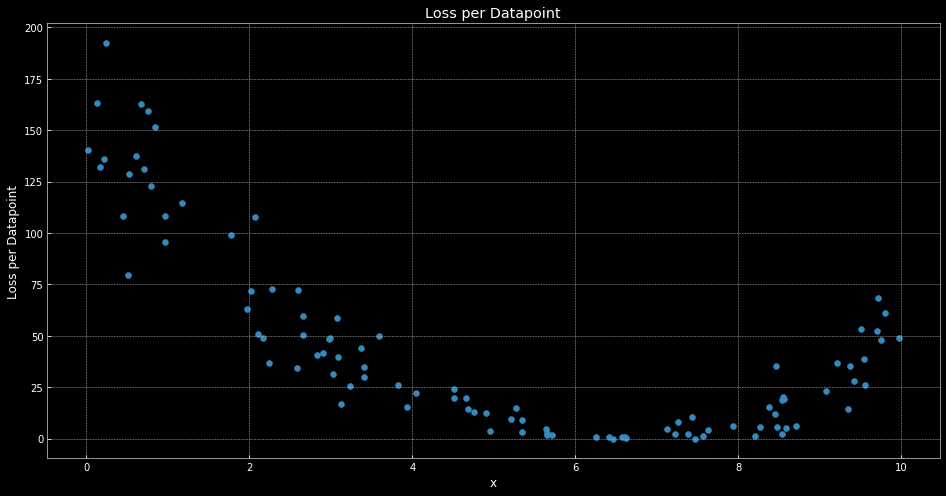

In [323]:
plt.scatter(x.detach(), loss_per_datapoint.detach(), label='Loss per Datapoint')
plt.title('Loss per Datapoint')
plt.ylabel('Loss per Datapoint')
plt.xlabel('x')
plt.show()

In [324]:
loss = torch.sum(loss_per_datapoint) / (2 * N)
print('loss = ' + str(loss))

loss = tensor(22.4137, grad_fn=<DivBackward0>)


So now we have a learning objective. Our learning objective is to create a machine learning model that has a loss of zero! Technically, the learning objective is the loss function itself, which is why we are free to choose what the learning objective/loss function is. Therefore, the next logical step we need to take is to figure out how to decrease this loss function in such a way that our model parameters become optimal. In other words, we need to figure out how to decrease the loss function with respect to our model parameters. If you have taken calculus before these words may be familiar....

# 2.0 The Learning Algorithm
So clearly we want to change the model parameters such that we start decreasing the loss function. In order to do this, we need to know how the loss function changes as we change the model parameters. In other words, we need a function of the form:

$$
\frac{\Delta\mathcal{L}}{\Delta\vec{\theta}} = g\left(\vec{x}, \vec{\theta}, \vec{y}\right)
$$

What this expression is saying is given some range of parameters, $\Delta\vec{\theta}$, this is how much on average $\Delta\mathcal{L}$ changes. Over that interval of $\Delta\vec{\theta}$, the loss function can go up and down, but we are simply just wondering how much it changed between the two endpoints. Now you may recall for a linear fuction $y = mx + b$, the slope, m, is equivalent to $\frac{\Delta y}{\Delta x}$. So really all this expression is asking for is the slope between two points on the loss function $\mathcal{L}$.

However, we only have a single point on the loss function, namely:

In [240]:
print('The loss is ' + str(loss) + ' at theta = ' + str(theta[0]))

The loss is tensor(30.6043, grad_fn=<DivBackward0>) at theta = tensor(4., grad_fn=<SelectBackward>)


So the question becomes how can we know the *instantaneous* rate of change of the loss function at any given point? Or in other words, as we let the distance between the two $\theta$ values change, what does the slope approach? This slope would be the slope of the tangential line to the curve at the given value. Here's a nice animation showing this process. Note that in the denominator we simply have $\Delta x = (a + h) - (a) = h$ for this animation, so that we are evaluating the instantaneous rate of change at $x = a$.

![title](images/derivatives.gif)

This instantaneous rate of change of a function has a name and is called the derivative of a function. You will not need to know how to evaluate derivatives for this class, but just know that, for example, the derivative of $y = x^2$ is $\frac{\partial y}{\partial x} = 2x$. Since I have given you this information, you should be able to then plot tangent lines to any point along the curve $y=x^2$, go ahead and try it out! 

In [211]:
def quadratic_tangents(x):
    y = x ** 2.0
    m = 2 * x
    b = y - m * x
    
    xs = np.arange(x - 5, x + 5, .01)
    quadratic_ys = xs ** 2
    tangent_ys = m * xs + b
    plt.plot(xs, quadratic_ys, label='y = x^2')
    plt.plot(xs, tangent_ys, label='Tangent line at x = ' + str(x))
    plt.legend()
    plt.show()
    print('derivative at x = ' + str(x) + ' is ' + str(m))

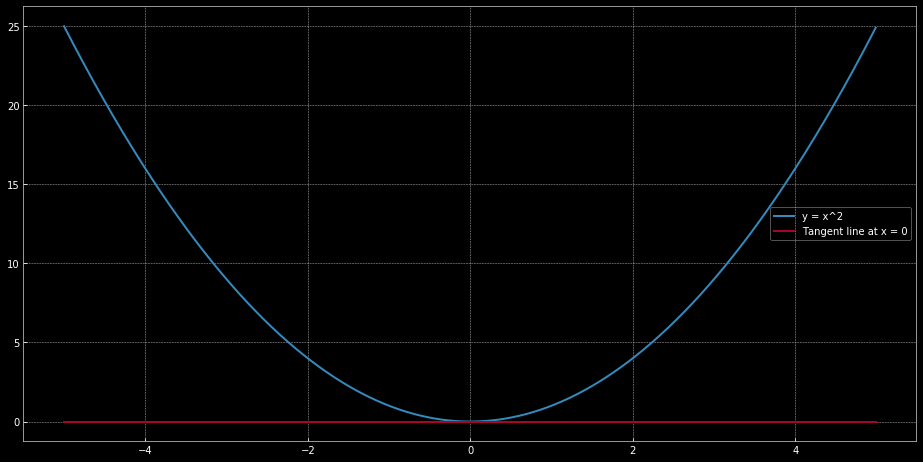

derivative at x = 0 is 0


In [212]:
quadratic_tangents(0)

$\partial$ just means an infinitesimal amount, so an infinitesimal change in y would be $\partial y$. So we can take our previous loss function and actually calculate the derivative, the instantaneous rate of change of the loss function, with respect to $\theta$ at any arbitrarily given $\theta$ value! This means we now know how the loss function changes at a given $\theta$ value!

For completeness, I will give the derivative of our loss function for linear regression below
$$
\frac{\partial \mathcal{L}}{\partial \theta_1} = \frac{1}{2N}\sum_{i = 1}^{N} \sum_{j = 1}^D 2 \cdot \left(x^{\left(i\right)} \cdot \theta_1 - y_j^{\left(i\right)}\right) \cdot \left(x^{\left(i\right)} - y_j^{\left(i\right)}\right)
$$

Now maybe it is clear why that 1/2 out front is put there customarily. ;)

We are almost there to the learning algorithm! Now, by studying the above quadratic example, you may have noted that when the slope of the tangent line is positive, the minimum in $y=x^2$, which is at $x = 0$, can be achieved by decreasing x. Simiarly, when the slope of the tangent line is negative, the minimum is to the right of the given value. In other words, we need to increase the value of x to achieve the minimum at $x=0$. As a concrete example, look at the derivative (slope of the tangent line) at $x=1.5$. This slope is positive. This means that we need to decrease x to get to the minimum. The amount we need to decrease x by is 1.5. Please note that at the minimum, the derivative/slope of the tangent line is zero! This is a very critical fact. Any minima or maxima of a function will always have the derivative be equal to zero at that point.

Now noting the above behavior, we may suggest that the way to "discover" the minima of a function is by simply subtracting the derivative from our given starting value:
$$
x_{t + 1} = x_t - \frac{\partial y}{\partial x}
$$
So let's try that!



In [127]:
x_0 = 1.5

for t in range(10):
    if t == 0:
        x_t = x_0
    else:
        x_t -= 2 * x_t
    print('At time t = ' + str(t) + ', x = ' + str(x_t) + ', and the loss is ' + str(x_t ** 2))

At time t = 0, x = 1.5, and the loss is 2.25
At time t = 1, x = -1.5, and the loss is 2.25
At time t = 2, x = 1.5, and the loss is 2.25
At time t = 3, x = -1.5, and the loss is 2.25
At time t = 4, x = 1.5, and the loss is 2.25
At time t = 5, x = -1.5, and the loss is 2.25
At time t = 6, x = 1.5, and the loss is 2.25
At time t = 7, x = -1.5, and the loss is 2.25
At time t = 8, x = 1.5, and the loss is 2.25
At time t = 9, x = -1.5, and the loss is 2.25


So clearly this does not work! What if instead of just subtracting the slope of the tangential line, we also multiply the slope by a number less than 1?

$$
x_{t + 1} = x_t - \alpha \frac{\partial y}{\partial x}
$$

In [128]:
x_0 = 1.5
alpha = 0.1

for t in range(10):
    if t == 0:
        x_t = x_0
    else:
        x_t -= alpha * 2 * x_t
    print('At time t = ' + str(t) + ', x = ' + str(x_t) + ', and the loss is ' + str(x_t ** 2))

At time t = 0, x = 1.5, and the loss is 2.25
At time t = 1, x = 1.2, and the loss is 1.44
At time t = 2, x = 0.96, and the loss is 0.9216
At time t = 3, x = 0.768, and the loss is 0.589824
At time t = 4, x = 0.6144000000000001, and the loss is 0.37748736000000005
At time t = 5, x = 0.49152000000000007, and the loss is 0.24159191040000005
At time t = 6, x = 0.39321600000000007, and the loss is 0.15461882265600005
At time t = 7, x = 0.31457280000000004, and the loss is 0.09895604649984002
At time t = 8, x = 0.25165824000000003, and the loss is 0.06333186975989762
At time t = 9, x = 0.20132659200000003, and the loss is 0.04053239664633448


We see now that the loss is decreasing! Let's now try plotting this...

In [203]:
def derivative_descent(x=1.5, T=10, alpha=0.01):
    xs = np.arange(-abs(x) - 0.5, abs(x) + 0.5, .01)
    quadratic_ys = xs ** 2
    plt.plot(xs, quadratic_ys, label='y = x^2')
    
    x_ts = []
    y_ts = []
    
    tangent_xs = np.array([])
    tangent_ys = np.array([])

    for t in range(T):
        if t == 0:
            x_t = x
            x_ts.append(x_t)
            y_ts.append(x_t ** 2)
        else:
            if x_t > 0:
                delta_x = np.arange(x_t - alpha * 2 * x_t, x_t, 0.001)
            else:
                delta_x = np.arange(x_t, x_t - alpha * 2 * x_t, 0.001)
            tangent_xs = np.concatenate((tangent_xs, delta_x))
            
            y = x_t ** 2.0
            m = 2 * x_t
            b = y - m * x_t
            
            tangent_ys = np.concatenate((tangent_ys, m * delta_x + b))
            
            if t == 1:
                plt.plot(delta_x, m * delta_x + b, label='Tangent lines', color='purple', linewidth=4.0)
            else:
                plt.plot(delta_x, m * delta_x + b, color='purple', linewidth=4.0)
            
            x_t -= alpha * 2 * x_t
            x_ts.append(x_t)
            y_ts.append(x_t ** 2.0)
                                        
    plt.scatter(x_ts, y_ts, label='x at different time steps', color='r', s=100)
    plt.legend()
    plt.show()

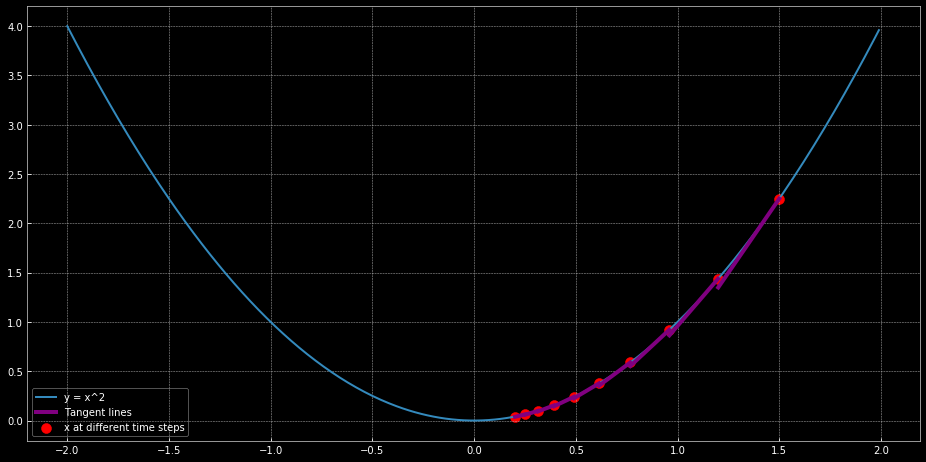

In [204]:
derivative_descent(x=1.5, T=10, alpha=0.1)

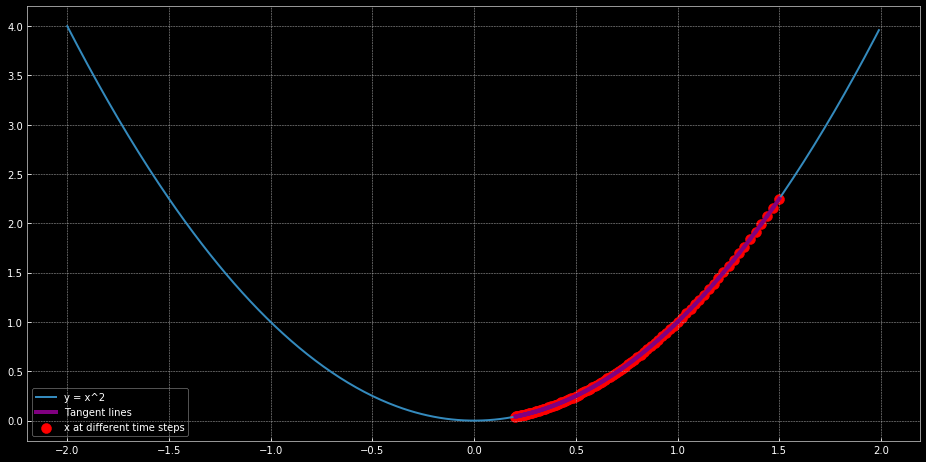

In [210]:
derivative_descent(x=1.5, T=100, alpha=0.01)

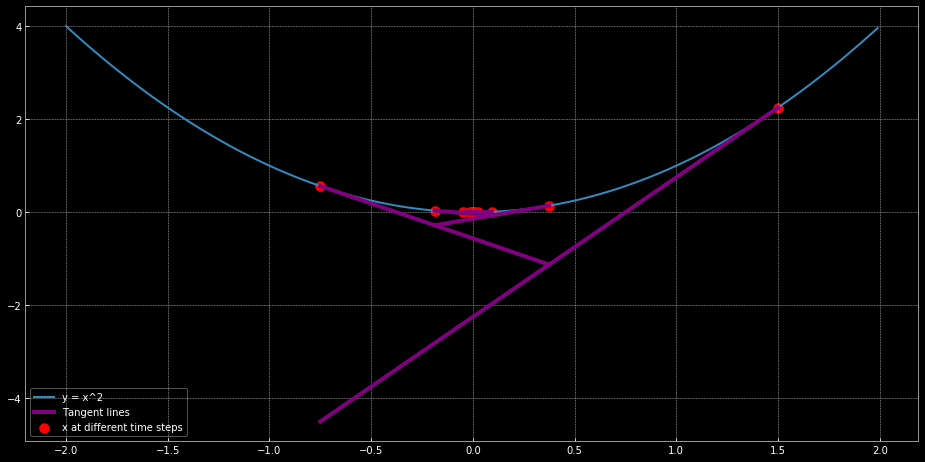

In [206]:
derivative_descent(x=1.5, T=100, alpha=0.75)

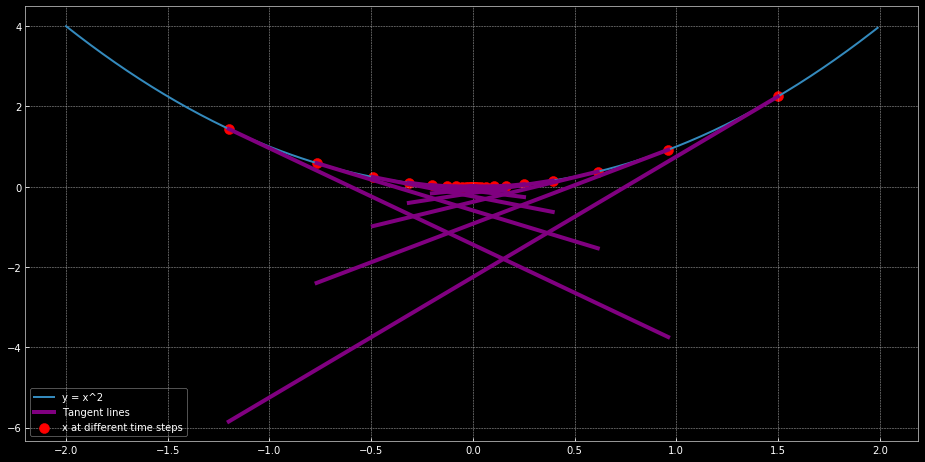

In [208]:
derivative_descent(x=1.5, T=100, alpha=0.9)

We have discovered our first learning algorithm! Substituting $\theta_1$ in for $x$ and $\mathcal{L}$ in for $y$ we get the update rule for our model's parameter:

$$
\theta_{1, t + 1} = \theta_{1, t} - \alpha \frac{\partial \mathcal{L}}{\partial \theta_1}
$$
This parameter $\alpha$ actually has a name and is called the **learning rate**. From the above plots you may have noticed that with a very small learning rate the number of time steps required to reach the minimum increases. This parameter is special in the sense that this is a parameter we much choose for our machine learning application, but it is not a parameter of the model. Parameters that fall in this class are called *hyperparameters* and will be a subject of further discussion.

So now that we have our first learning algorithm, let's try it out! One nice thing about PyTorch is we don't have to worry about the computation of the derivative. We can simply call `loss.backward()` and what this does is it lets us calculate the derivative of the loss with respect to any variable by calling `variable.grad`!

In [325]:
loss.backward()

In [326]:
x.grad # dL/dx

In [327]:
theta.grad # dL/dtheta

tensor([-4.0143])

Let's now train our linear regression model!

In [328]:
losses = []
learning_rate = 0.001

for t in range(100):
    y_pred = theta[0] * x
    loss_per_datapoint = (y_true - y_pred).pow(2)
    loss = torch.sum(loss_per_datapoint) / (2 * N)
    losses.append(loss)
    
    loss.backward()
    theta.data -= learning_rate * theta.grad.data
    theta.grad = None

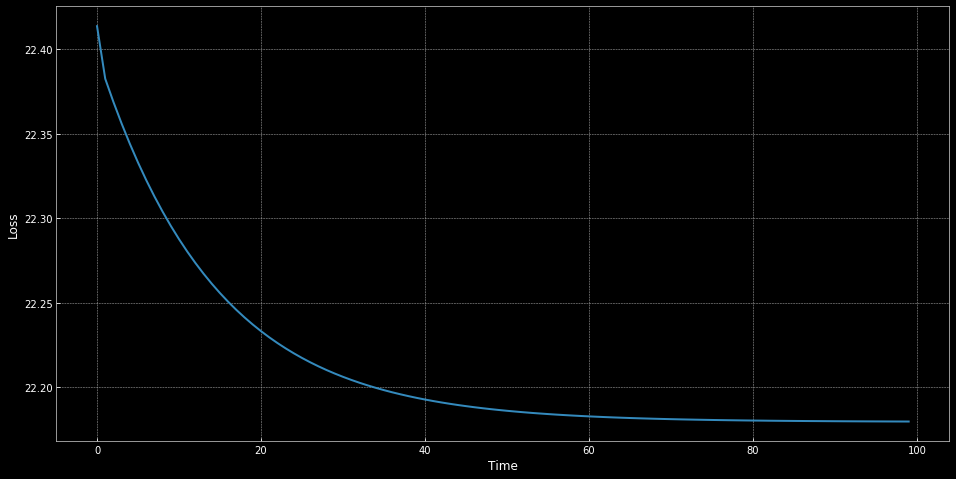

In [332]:
plt.plot(np.arange(0, len(losses), 1), losses)
plt.ylabel('Loss')
plt.xlabel('Time')
plt.show()

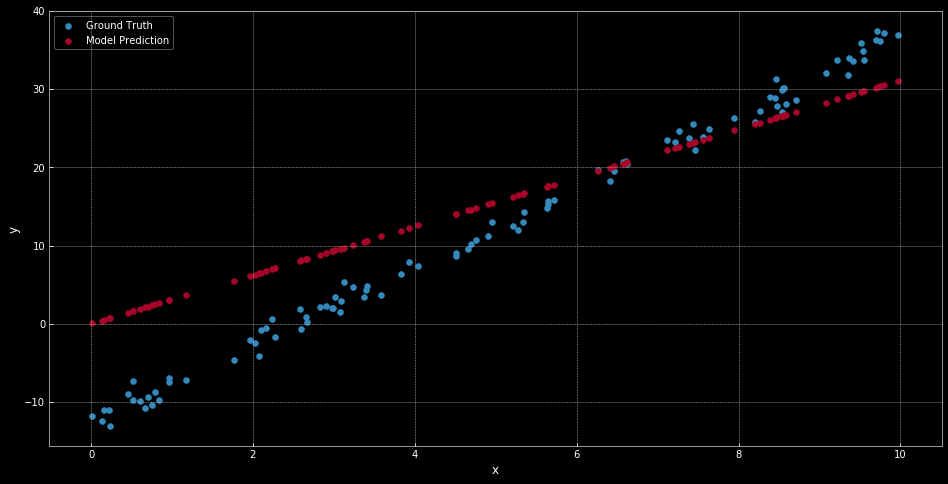

In [333]:
plt.scatter(x.detach().numpy(), y_true.detach().numpy(), label="Ground Truth")
plt.scatter(x.detach().numpy(), y_pred.detach().numpy(), label='Model Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

And now we are done! "But wait!", surely you are saying. "This model is not any good! What if we just add a y-intercept into the model. This is surely not too complicated and will get much better performance!" I'm glad you said so! Let's go ahead and do that real quick...

In [335]:
theta = torch.Tensor(2).random_(20)
theta.requires_grad = True

In [336]:
slope = 4.928 # This is a parameter that our model needs to learn to predict accurately
y_intercept = -12.52 # This is another parameter that our model needs to learn to predict accurately
y_true = slope * x + noise + y_intercept
y_pred = theta[0] * x + theta[1]

In [337]:
loss_per_datapoint = (y_true - y_pred).pow(2)
loss = torch.sum(loss_per_datapoint) / (2 * N)

In [338]:
loss.backward()

In [339]:
theta.grad

tensor([375.2766,  61.7170])

But wait a second! We have two different derivatives now! How can that be...? How can a function have two different tangential slopes at a given point? Well, the problem is we have actually left the 2-dimensional world and have entered the realm of multivariate calculus or 3-dimensional functions. Now, functions in 3-dimensions no longer have tangential *lines* but **tangential planes**. The equation for a plane in 3 dimensions, if you have never seen it before, is:
$$
z = ax + by + c
$$
Look like the familiar $y = mx + b$? We can also define a plane in 3 dimensions by specifying two slopes that are orthogonal (90 degrees to one another) and a z-intercept, $c$. Therefore, the equation for a tangential plane is thus:
$$
z = \frac{\partial \mathcal{L}}{\partial x}x + \frac{\partial \mathcal{L}}{\partial y}y + c
$$

In fact, we can create a new object out of these derivatives called the *gradient*:
$$
\nabla z = \langle \frac{\partial z}{\partial x}, \frac{\partial z}{\partial y} \rangle
$$
The gradient tells us in what direction to step in (how much in the x direction and how much in the y direction) in multiple dimensions in order to maximize our function. Imagine climbing up a hill. The quickest way up a hill would be to follow the gradient of the hill.

As before, as a concrete example we can use the function:
$$
z = x^2 + y^2
$$
which has the gradient
$$
\nabla z = \langle 2x, 2y \rangle
$$

In [345]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [362]:
def paraboloid_tangents(x, y, x_range=1.0, y_range=1.0):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    z = x ** 2 + y ** 2
    grad = (2 * x, 2 * y)
    c = z - grad[0] * x - grad[1] * y
    
    print('Gradient = ' + str(grad))
    
    X = np.arange(x - x_range, x + x_range, 0.01)
    Y = np.arange(y - y_range, y + y_range, 0.01)
    X, Y = np.meshgrid(X, Y)
    Z = X ** 2 + Y ** 2
    plane = grad[0] * X + grad[1] * Y + c
    
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    surf2 = ax.plot_surface(X, Y, plane)
    plt.show()
    

Gradient = (2, 2)


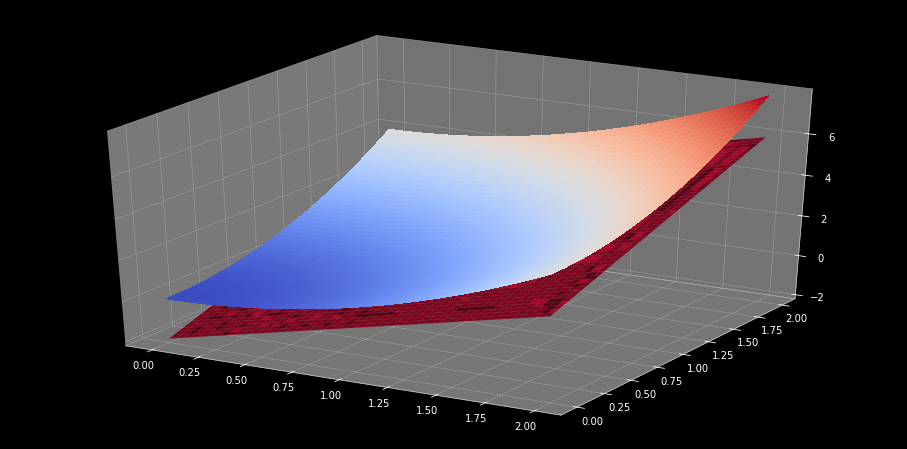

In [366]:
paraboloid_tangents(1, 1)

Gradient = (2, 2)


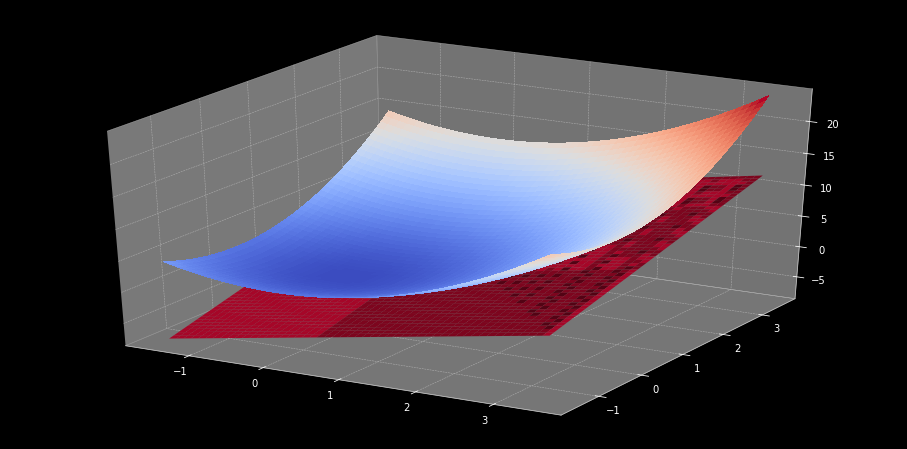

In [365]:
paraboloid_tangents(1, 1, x_range=2.5, y_range=2.5)

So now we know why there are two derivatives... it is just $\frac{\partial \mathcal{L}}{\partial \theta_1}$ and $\frac{\partial \mathcal{L}}{\partial \theta_2}$. However, we need to update our learning algorithm to include the generalization to multiple dimensions:

$$
\vec{\theta}_{t + 1} = \vec{\theta}_{t} - \alpha \nabla_{\vec{\theta}}\mathcal{L}
$$
where $\nabla_{\vec{\theta}}$ just means the gradient with respect to $\vec{\theta}$. This learning algorithm is called gradient descent! If we wanted to instead maximize a loss function $\mathcal{L}$, we would add the gradient and this would be gradient ascent. This is one of the most ubiquitous learning algorithms in machine learning and there exist many variants of learning algorithms that all employ information about the gradient (or higher order derivatives...Hessian anyone?) to teach the machine. These are called gradient-based learning algorithms, some of which we will discuss in the next lab.

Alright, so now let's finally train a model with two parameters!

In [396]:
losses = []
learning_rate = 0.01
T = 10000

theta = torch.Tensor(2).random_(20)
theta.requires_grad = True

for t in range(T):
    y_pred = theta[0] * x + theta[1]
    loss_per_datapoint = (y_true - y_pred).pow(2)
    loss = torch.sum(loss_per_datapoint) / (2 * N)
    losses.append(loss)
    
    loss.backward()
    theta.data -= learning_rate * theta.grad.data
    theta.grad = None

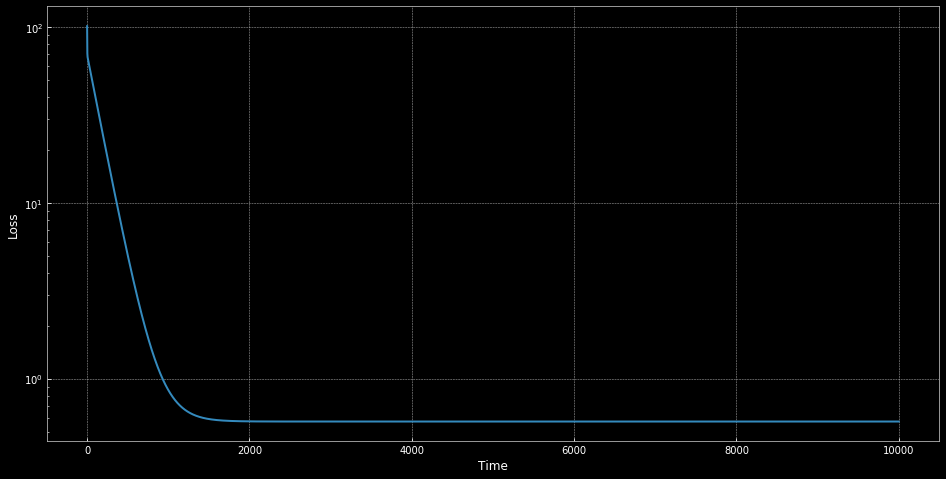

In [397]:
plt.plot(np.arange(0, len(losses), 1), losses)
plt.ylabel('Loss')
plt.xlabel('Time')
plt.yscale('log')
plt.show()

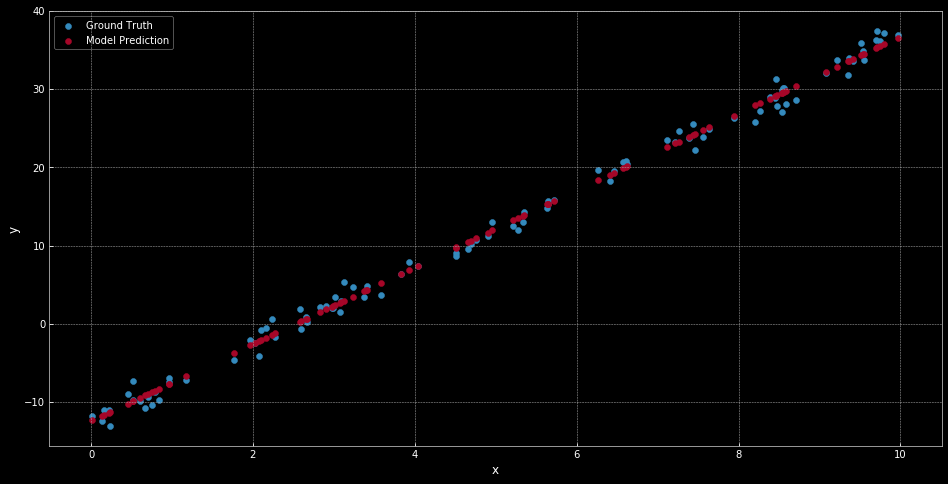

In [398]:
plt.scatter(x.detach().numpy(), y_true.detach().numpy(), label="Ground Truth")
plt.scatter(x.detach().numpy(), y_pred.detach().numpy(), label='Model Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Note that the loss plot is now plotted on a log axis. This is because if it is not on a log axis it is easy to assume that you may be finished training but the model's performance will still be sub-optimal. Go ahead and try messing with the learning rate and number of iterations (T) to see how loss changes and what the model looks like.

# We have trained our first machine learning model!

## Exercise 1
Create a linear regression model to fit the following `train_data` given the `y_true` ground truth values.

In [445]:
# Exercise 1
x = 5 * torch.rand(1000).reshape(1000, 1)
y = 5 * torch.rand(1000).reshape(1000, 1)
noise = torch.randn(1000).reshape(1000, 1)
train_data = torch.cat((x, y), dim=1)

y_true = 3.32 * x - 1.18 * y + 5.42 + 2 * noise

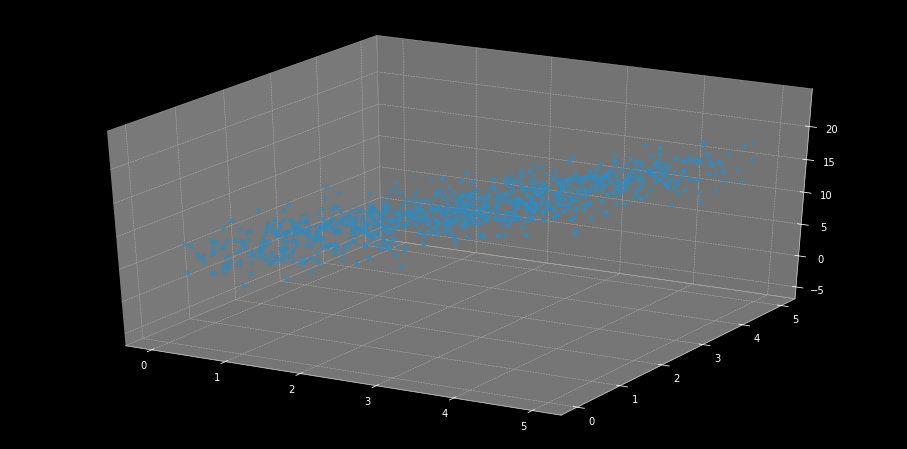

In [446]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.scatter(x.numpy().flatten(), y.numpy().flatten(), y_true.numpy().flatten())
plt.show()

In [447]:
# put training loop here

In [ ]:
# plot loss as a function of time here

In [ ]:
# plot predictions vs ground truth here

## Exercise 2
Try and create a linear regression for the following dataset that achieves a very low mean squared error loss. Hint: You can "augment" the training data however you please. This is a common practice called "feature engineering" where you try and make the data more easily learned by the machine learning model.

In [492]:
# Exercise 2
x = 2 * (torch.rand(1000).reshape(1000, 1) - 0.5)
y = 2 * (torch.rand(1000).reshape(1000, 1) - 0.5)
noise = torch.randn(1000).reshape(1000, 1)
train_data = torch.cat((x, y), dim=1)

y_true = (-10 * (x ** 2)) + (5 * (y ** 3))

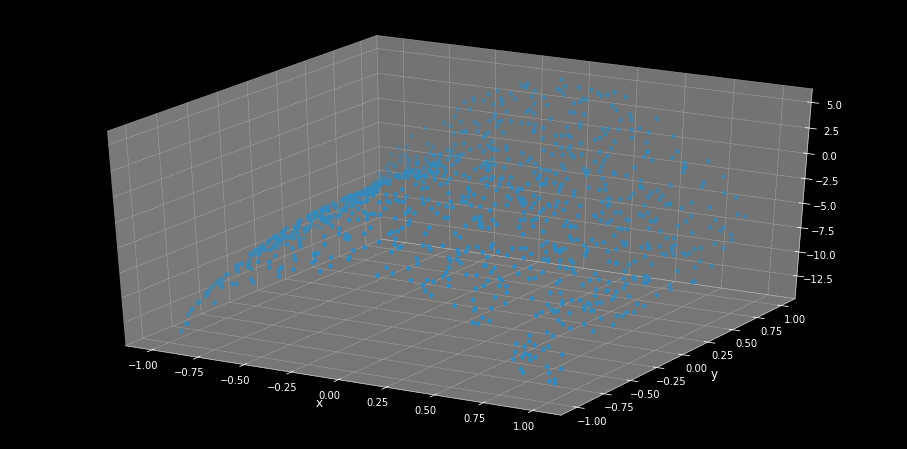

In [493]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.scatter(x.numpy().flatten(), y.numpy().flatten(), y_true.numpy().flatten())
plt.ylabel('y')
plt.xlabel('x')
plt.show()

In [ ]:
# put any data augmentation here

In [ ]:
# put training loop here

In [ ]:
# plot loss as a function of time here

In [ ]:
# plot predictions vs ground truth here

## Exercise 3
I mentioned that another task is performing classification instead of linear regression. To perform classification you need to use a different function instead of the hyperplane (multidimensional line ;)). The simplest model for classification is the logistic function:
$$
\hat{y} = \frac{1}{1 - e^{-\vec{\theta} \cdot \vec{x}}}
$$
where the logistic function for 1D is:
$$
\hat{y} = \frac{1}{1 - e^{-\left(\theta_1 * x_1 + \theta_2\right)}}
$$

Use this function to classify the following 1D data:

Note: You will also likely want to use a different loss function than MSE. For binary classification (this task here), a common loss function used is Binary Cross-entropy (BCE):
$$
\mathcal{L} = -\frac{1}{N}\sum_{i=1}^{N} y_i log(\hat{y}_i) + (1 - y_i) log(1 - \hat{y}_i)
$$


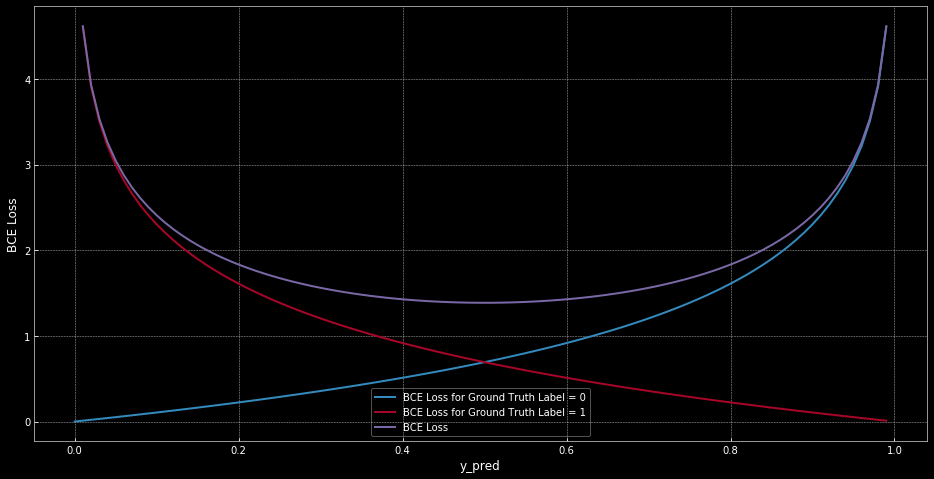

In [9]:
y_pred = torch.arange(0, 1, 0.01)
class_0_loss = -torch.log(1 - y_pred)
class_1_loss = -torch.log(y_pred)
plt.plot(y_pred.numpy(), class_0_loss.numpy(), label='BCE Loss for Ground Truth Label = 0')
plt.plot(y_pred.numpy(), class_1_loss.numpy(), label='BCE Loss for Ground Truth Label = 1')
plt.plot(y_pred.numpy(), (class_0_loss + class_1_loss).numpy(), label='BCE Loss')
plt.xlabel('y_pred')
plt.ylabel('BCE Loss')
plt.legend()
plt.show()

In [504]:
x = 4 * (torch.rand(1000).reshape(1000, 1) - 0.5)
noise = torch.randn(1000).reshape(1000, 1) / 4

y_true = (torch.sign(x + 1.5 + noise) + 1) / 2

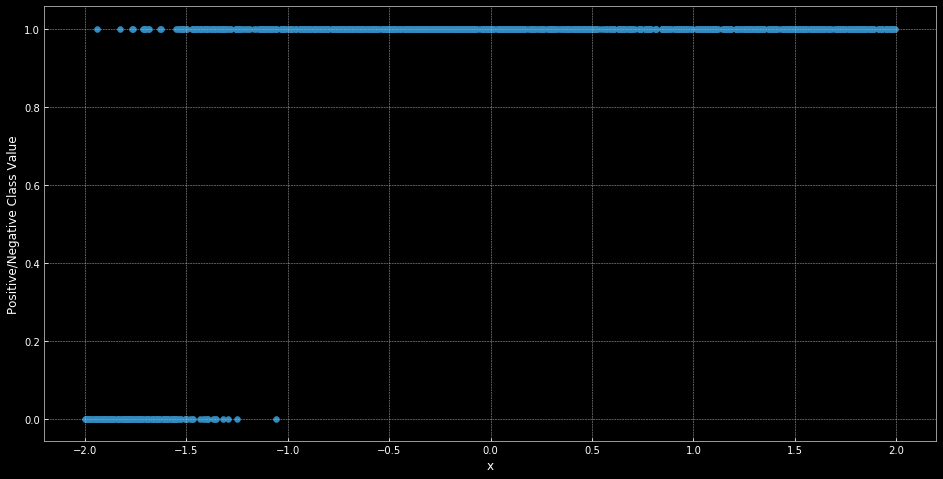

In [506]:
plt.scatter(x.numpy().flatten(), y_true.numpy().flatten())
plt.xlabel('x')
plt.ylabel('Positive/Negative Class Value')
plt.show()

In [ ]:
# put training loop here

In [ ]:
# plot loss as a function of time here

In [ ]:
# plot predictions vs ground truth here